In [75]:
import sys
import os
import time
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/public/workspace/ruru_97/projects/schgnn/csMAHN')
import utils.preprocess as pp
from utils.utility import *
from utils.train import Trainer
from utils.plot import plot_umap

import importlib as im
im.reload(pp)

<module 'utils.preprocess' from '/public/workspace/ruru_97/projects/schgnn/csMAHN/utils/preprocess.py'>

In [76]:
reverse=False
aligned=False
tissue = "lung"
gse_ids = ["GSE127465","GSE127465"]
species = ('human', 'mouse')
dsnames = ('human_t', 'mouse_t')
path_data='/public/workspace/ruru_97/projects/data'
resdir='/public/workspace/ruru_97/projects/schgnn/result'
homo_method='biomart'
key_class='cell_type'
n_hvgs=2000
n_degs=50

seed = 123
stages=[200, 200, 200]
nfeats=64  # enbedding size #128
hidden=64 # 128
input_drop=0.2
att_drop=0.2
residual=True

threshold=0.9 # 0.8
lr=0.01  # lr = 0.01
weight_decay=0.001
patience=100
enhance_gama=10
simi_gama=0.1 

In [77]:
# reverse reference to query, query to reference.
if reverse:
    gse_ids = gse_ids[::-1]
    species = species[::-1]
    dsnames = dsnames[::-1]
seed_all(seed)
path_homo = f'{path_data}/homo/{homo_method}/input/{species[0]}_to_{species[1]}.txt'
path_specie_1 = f'{path_data}/ByTissue/{tissue}/{gse_ids[0]}/input/{dsnames[0]}.h5ad'
path_specie_2 = f'{path_data}/ByTissue/{tissue}/{gse_ids[1]}/input/{dsnames[1]}.h5ad'

homo = pd.read_csv(path_homo)
adata_species_1 = sc.read_h5ad(path_specie_1)
adata_species_2 = sc.read_h5ad(path_specie_2)

if aligned:
    adata_species_1, adata_species_2 = pp.aligned_type([adata_species_1, adata_species_2], 'cell_type')


In [78]:
# make file to save
time_tag = make_nowtime_tag()
curdir = f'{resdir}/{tissue}/{tissue}-{gse_ids[0]}_{dsnames[0]}-{gse_ids[1]}_{dsnames[1]}-{time_tag}'
model_dir = os.path.join(curdir, 'model_')
figdir = os.path.join(curdir, 'fig_')
os.mkdir(curdir)
os.mkdir(figdir)
os.mkdir(model_dir)
checkpt_file = model_dir + "/mutistages"
print(checkpt_file)

for i in range(len(stages)):
    res_dir = os.path.join(curdir, f'res_{i}')
    os.mkdir(res_dir)

/public/workspace/ruru_97/projects/schgnn/result/lung/lung-GSE127465_human_t-GSE127465_mouse_t-03-05-15.55.04/model_/mutistages


In [79]:
DC_type = ['tDC1','tDC2','tDC3','tpDC']
# mac_mono_type = ['tMac3','tMac1','tMac2','tMac8','tMac4','tMac7','tMac6','tMacCycl','tMac5','tMac9','tMonoDC','tMono3','tMono2','tMono1']
adata_species_2.obs['Minor subset'] = 't'+adata_species_2.obs['Minor subset'].astype('string')
adata_species_1 = adata_species_1[adata_species_1.obs['Minor subset'].isin(DC_type)]
adata_species_2 = adata_species_2[adata_species_2.obs['Minor subset'].isin(DC_type)]

In [54]:
print(
    f'Task: refernece:{gse_ids[0]}_{dsnames[0]} {adata_species_1.shape[0]} cells x {adata_species_1.shape[1]} gene -> query:{gse_ids[1]}_{dsnames[1]} {adata_species_2.shape[0]} cells x {adata_species_2.shape[1]} gene in {tissue}')

Task: refernece:GSE127465_human_t 913 cells x 41861 gene -> query:GSE127465_mouse_t 570 cells x 28205 gene in lung


In [32]:
pp.get_type_counts_info([adata_species_1,adata_species_2],key_class='Minor subset',dsnames=['human','mouse'])

,human,mouse
Minor subset,,
tDC2,330,106
tpDC,311,52
tDC1,171,119
tDC3,101,293


In [34]:
start = time.time()
key_class = 'Minor subset'
# knn时间较长
adatas, features_genes, nodes_genes, scnets, one2one, n2n = pp.process_for_graph([adata_species_1, adata_species_2],
                                                                                    homo,
                                                                                    key_class,
                                                                                    'leiden',
                                                                                    n_hvgs=n_hvgs,
                                                                                    n_degs=n_degs)
g, inter_net, one2one_gene_nodes_net, cell_label, n_classes, list_idx = pp.make_graph(adatas,
                                                                                        aligned,
                                                                                        key_class,
                                                                                        features_genes,
                                                                                        nodes_genes,
                                                                                        scnets,
                                                                                        one2one,
                                                                                        n2n,
                                                                                        has_mnn=True,
                                                                                        seed=seed)
end = time.time()
# 包括预处理时间
print('Times preprocess for graph:{:.2f}'.format(end - start))

Homolog information follows
Mouse homology type
ortholog_one2one      16612
ortholog_many2many     5356
ortholog_one2many      3174
Name: count, dtype: int64
the time2 of processing adatas is 2.7919793128967285
Leiden results:
leiden
0    308
1    216
2     46
Name: count, dtype: int64
the time of leiden is 0.2689981460571289
the time of degs is 6.211021423339844
--------------hvgs, degs info---------------
num of reference_hvgs,reference_degs,reference_higs are 2000,185,2145
num of query_hvgs,query_degs,query_higs are 2000,147,2125
--------------gene nodes info---------------
num of reference_gene_node is 3781
num of query_gene_node is 3466
--------------homo edges---------------
Mouse homology type
ortholog_one2one      2885
ortholog_one2many      284
ortholog_many2many     176
Name: count, dtype: int64
--------------homo edges---------------
Mouse homology type
ortholog_one2one    2885
Name: count, dtype: int64
knn time is 27.384122371673584 s
mnn time is 0.0016703605651855469 s
the

In [35]:
import utils.train as train1
im.reload(train1)

<module 'utils.train' from '/public/workspace/ruru_97/projects/schgnn/csMAHN/utils/train.py'>

In [37]:
seed_all(123)
trainer = train1.Trainer(adatas,
                    g,
                    inter_net,
                    list_idx,
                    cell_label,
                    n_classes,
                    threshold=0.9,
                    weight_decay=0.01,
                    key_class=key_class
                    )
out = trainer.train(curdir=curdir, 
            checkpt_file=checkpt_file,
            stages=[200,200,200],
            best_point_epoch=20,
            patience=100,
            nfeats=nfeats,
            hidden=hidden,
            enhance_gama=enhance_gama,
            simi_gama=simi_gama,
            dsnames=dsnames,
            )

MYHGNN(
  (prelu): PReLU(num_parameters=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (input_drop): Dropout(p=0.2, inplace=False)
  (cell_embedings): ParameterDict(
      (C): Parameter containing: [torch.FloatTensor of size 228x64]
      (CC): Parameter containing: [torch.FloatTensor of size 228x64]
      (CCGGC): Parameter containing: [torch.FloatTensor of size 228x64]
      (CGGC): Parameter containing: [torch.FloatTensor of size 228x64]
      (CGGCC): Parameter containing: [torch.FloatTensor of size 228x64]
      (CCGGCC): Parameter containing: [torch.FloatTensor of size 228x64]
  )
  (cell_project_layers): Sequential(
    (0): Conv1d1x1()
    (1): LayerNorm((6, 64), eps=1e-05, elementwise_affine=True)
    (2): PReLU(num_parameters=1)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv1d1x1()
    (5): LayerNorm((6, 64), eps=1e-05, elementwise_affine=True)
    (6): PReLU(num_parameters=1)
    (7): Dropout(p=0.5, inplace=False)
  )
  (cell_semantic_aggr_layers): Transformer(
    (

In [92]:
df = pd.DataFrame(data=None)
df['true_label'] = np.concatenate(pp.get_labels_from_adatas(trainer.adatas, trainer.key_class))
df['pre_label'] = trainer.output.argmax(dim=-1).detach().numpy()
df['pre_label'].replace(trainer.encode_and_types[0], trainer.encode_and_types[1], inplace=True)
df = df[trainer.adatas[0].shape[0]:]
df['count'] = 1
confuse_matrix = df.pivot_table(index='true_label', columns='pre_label', values='count', aggfunc='sum').fillna(0).astype(int)
confuse_matrix_pro = confuse_matrix.div(confuse_matrix.sum(axis=1),axis=0)

<Axes: xlabel='pre_label', ylabel='true_label'>

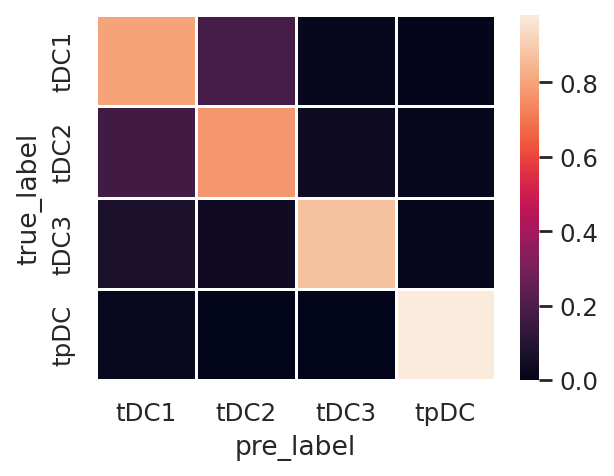

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# Load the example flights dataset and convert to long-form
flights_long = sns.load_dataset("flights")
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(confuse_matrix_pro,linewidths=.5, ax=ax)

In [57]:
adt = sc.AnnData(trainer.embedding_hidden.detach().numpy())
adt.obs = pd.concat([adata_species_1.obs,adata_species_2.obs])
adt.obs['dataset'] = [dsnames[0]] * adatas[0].shape[0] + [dsnames[1]] * adatas[1].shape[0]
sc.set_figure_params(dpi_save=200)
sc.settings.figdir = figdir
sc.pp.neighbors(adt, n_neighbors=15, metric='cosine', use_rep='X')
sc.tl.umap(adt)

In [80]:
sc.pp.normalize_total(adata_species_1, target_sum=1e6)
sc.pp.log1p(adata_species_1)

sc.pp.normalize_total(adata_species_2, target_sum=1e6)
sc.pp.log1p(adata_species_2)

In [81]:
adt1 = adt[:adata_species_1.shape[0]]
adt2 = adt[adata_species_1.shape[0]:]
adata_species_1.obs['X_umap_1'] = adt1.obsm['X_umap'][:,0].tolist()
adata_species_1.obs['X_umap_2'] = adt1.obsm['X_umap'][:,1].tolist()
adata_species_2.obs['X_umap_1'] = adt2.obsm['X_umap'][:,0].tolist()
adata_species_2.obs['X_umap_2'] = adt2.obsm['X_umap'][:,1].tolist()

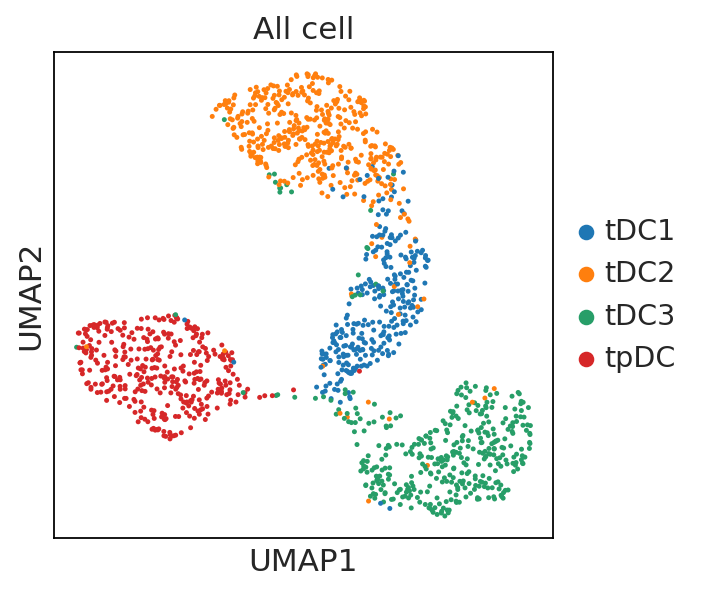

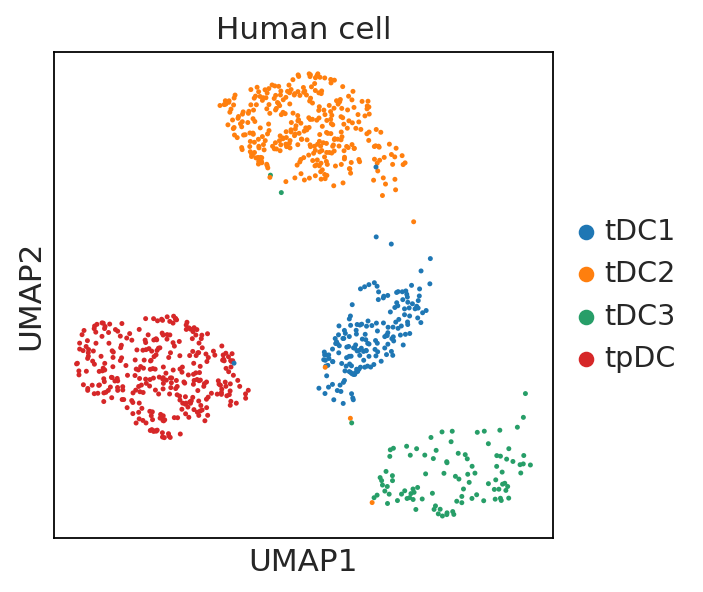

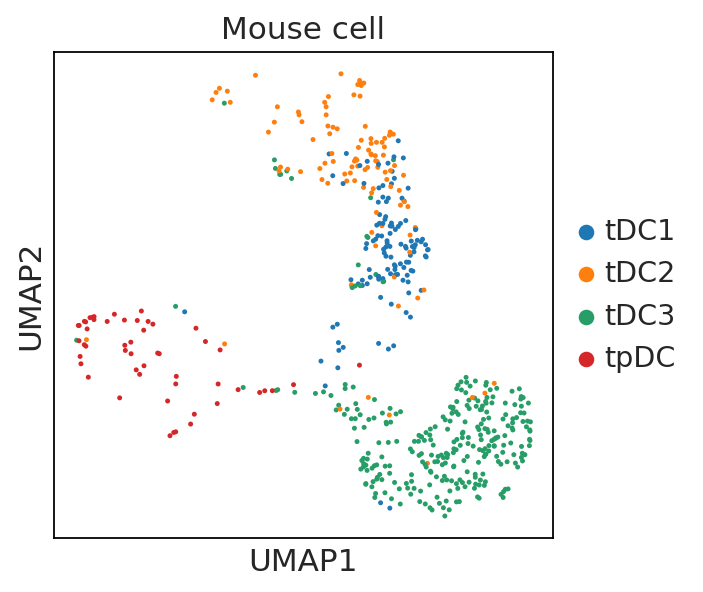

In [89]:
key_class = 'Minor subset'
sc.pl.umap(adt,color=key_class,title='All cell',size=20)
sc.pl.umap(adt[:adata_species_1.shape[0]],color=key_class,title='Human cell',size=20)
sc.pl.umap(adt[adata_species_1.shape[0]:],color=key_class,title='Mouse cell',size=20)

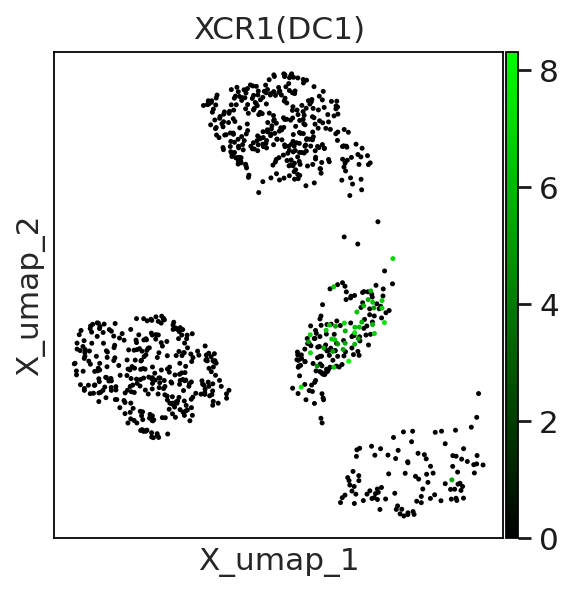

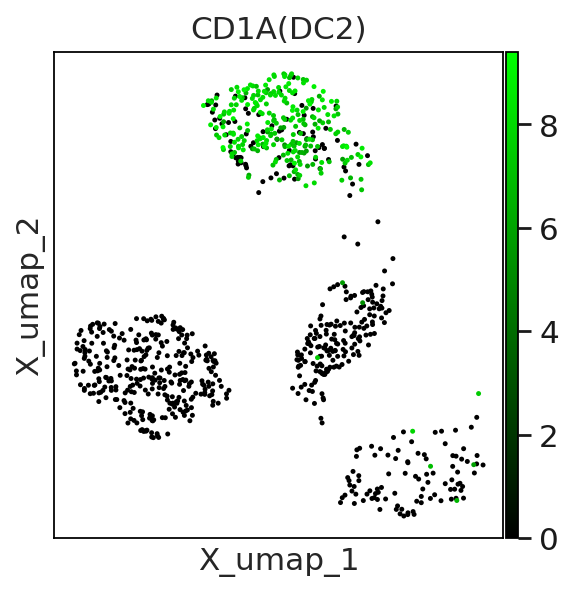

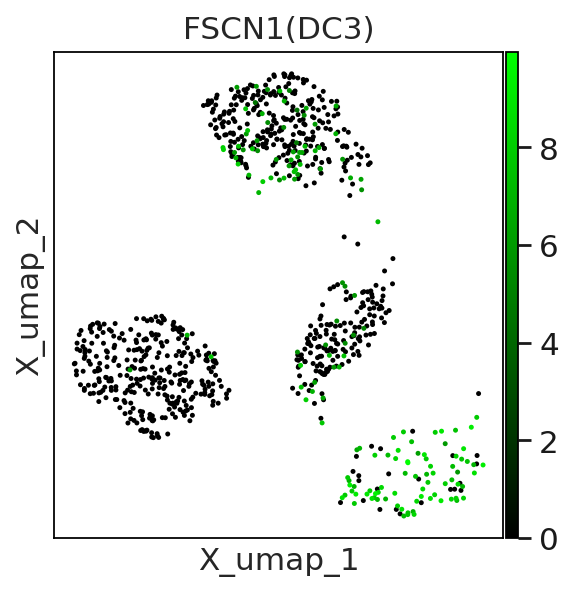

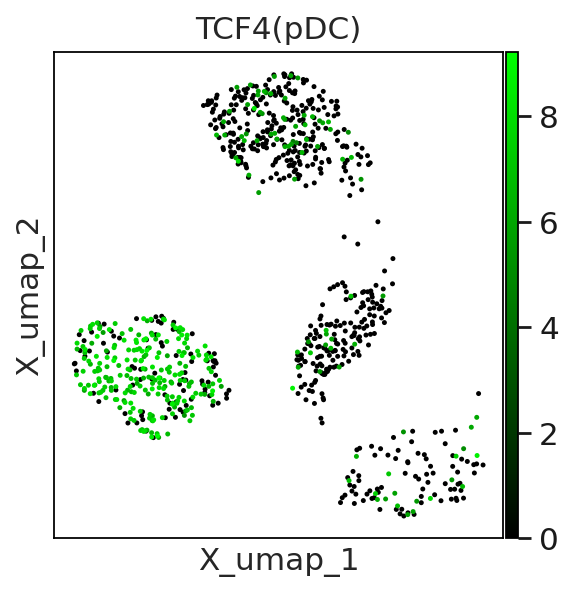

In [91]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# 创建一个颜色映射，0%表达为黑色，100%表达为绿色
sc.set_figure_params(dpi_save=300)
cmap = LinearSegmentedColormap.from_list('custom_green', ['black','#00FF00'], N=256)
genes = ['XCR1','CD1A','FSCN1','TCF4']
types = ['DC1','DC2','DC3','pDC']
for gene, type in zip(genes,types):
    ax = sc.pl.scatter(adata_species_1, x='X_umap_1', y='X_umap_2', color=gene,color_map=cmap,  title=f'{gene}({type})',show=False,size=20)
    ax.grid(False)  # 去除网格
    # ax.set_frame_on(False)  # 去除边框
    ax.set_xticks([])  # 去除x轴刻度
    ax.set_yticks([])  # 去除y轴刻度
    # ax.set_xticklabels([])  # 去除x轴标签
    # ax.set_yticklabels([])  # 去除y轴标签

    plt.show()

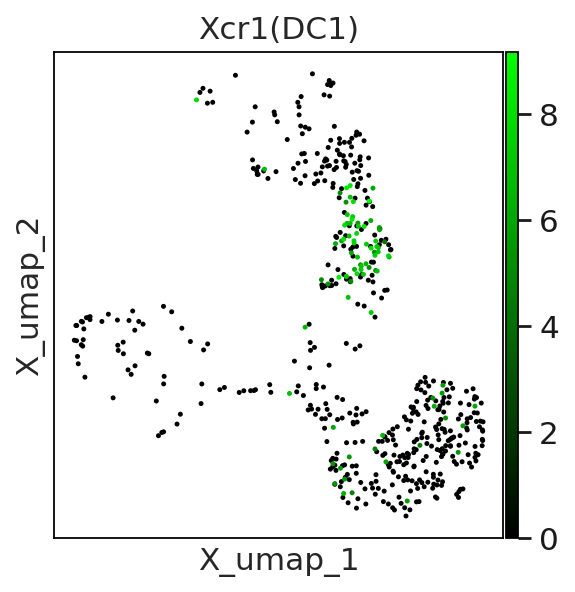

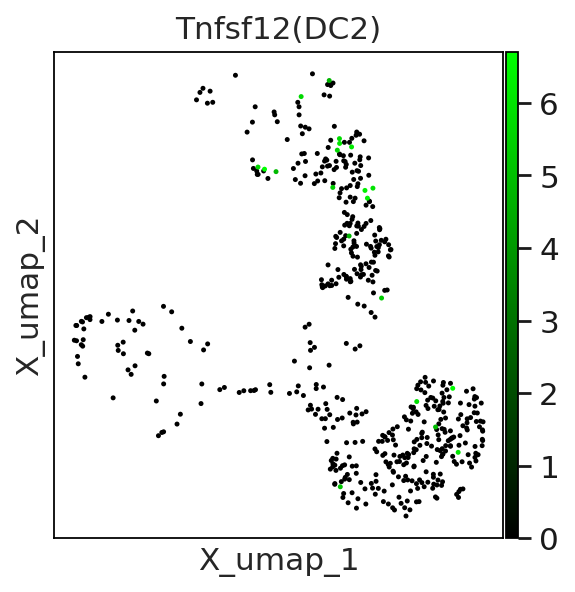

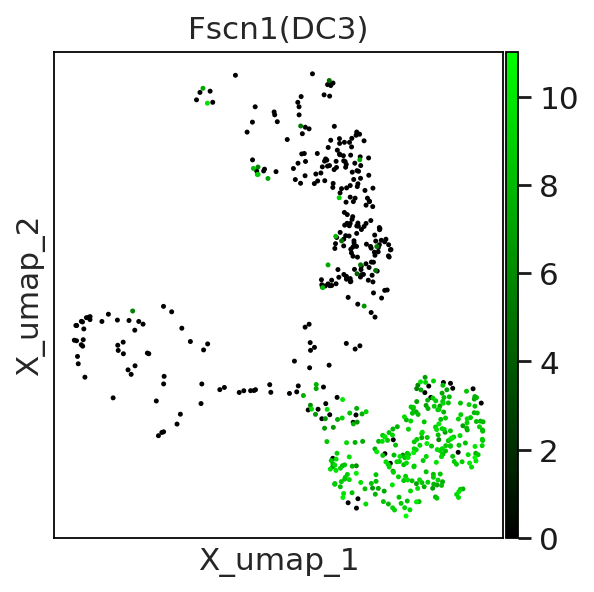

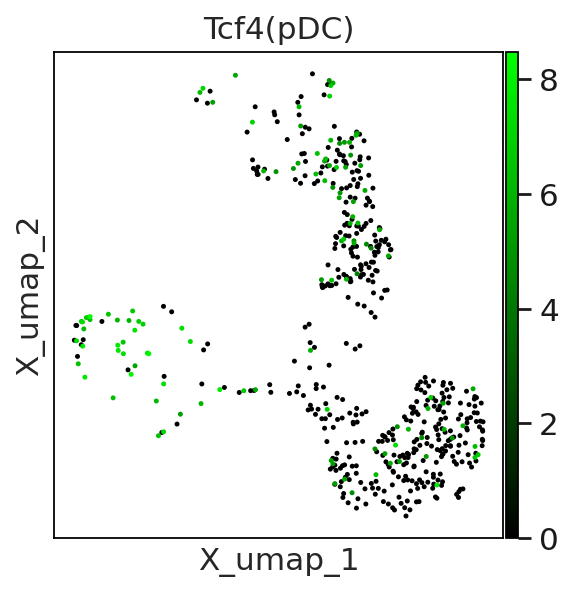

In [87]:
genes = ['Xcr1','Tnfsf12','Fscn1','Tcf4']
types = ['DC1','DC2','DC3','pDC']
for gene, type in zip(genes,types):
    ax = sc.pl.scatter(adata_species_2, x='X_umap_1', y='X_umap_2', color=gene,color_map=cmap,  title=f'{gene}({type})',show=False, size=20)
    ax.grid(False)  # 去除网格
    # ax.set_frame_on(False)  # 去除边框
    ax.set_xticks([])  # 去除x轴刻度
    ax.set_yticks([])  # 去除y轴刻度
    # ax.set_xticklabels([])  # 去除x轴标签
    # ax.set_yticklabels([])  # 去除y轴标签

    plt.show()